# Predicting

## Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from typing import Callable

## Load dataset

In [2]:
df = pd.read_csv('../data/prepared.csv')
df.head()

,movie,year,category,nominee,bafta,globe,oscar,rated,runtime,director,...,musical,romance,music,action,drama,comedy,sport,history,animation,thriller
0,Raging Bull,1980,actor,Robert De Niro,0,1,1,R,129,Martin Scorsese,...,0,0,0,0,1,0,1,0,0,0
1,Raging Bull,1980,director,Martin Scorsese,0,0,0,R,129,Martin Scorsese,...,0,0,0,0,1,0,1,0,0,0
2,Raging Bull,1980,picture,Raging Bull,0,0,0,R,129,Martin Scorsese,...,0,0,0,0,1,0,1,0,0,0
3,The Great Santini,1980,actor,Robert Duvall,0,0,0,PG,115,Lewis John Carlino,...,0,0,0,0,1,0,0,0,0,0
4,The Elephant Man,1980,actor,John Hurt,1,0,0,PG,124,David Lynch,...,0,0,0,0,1,0,0,0,0,0


## Encode categorical values

In [3]:
encoder = LabelEncoder()
df['rated'] = encoder.fit_transform(df.rated)
df['director'] = encoder.fit_transform(df.director)
df['language'] = encoder.fit_transform(df.language)

In [4]:
df.head()

,movie,year,category,nominee,bafta,globe,oscar,rated,runtime,director,...,musical,romance,music,action,drama,comedy,sport,history,animation,thriller
0,Raging Bull,1980,actor,Robert De Niro,0,1,1,4,129,162,...,0,0,0,0,1,0,1,0,0,0
1,Raging Bull,1980,director,Martin Scorsese,0,0,0,4,129,162,...,0,0,0,0,1,0,1,0,0,0
2,Raging Bull,1980,picture,Raging Bull,0,0,0,4,129,162,...,0,0,0,0,1,0,1,0,0,0
3,The Great Santini,1980,actor,Robert Duvall,0,0,0,2,115,152,...,0,0,0,0,1,0,0,0,0,0
4,The Elephant Man,1980,actor,John Hurt,1,0,0,2,124,57,...,0,0,0,0,1,0,0,0,0,0


## Split train and test data

In [5]:
predict_year = 2020
categories = pd.unique(df.category)

In [6]:
train = df[df.year < predict_year]
test = df[df.year == predict_year]

## Predict

In [7]:
to_drop = ['movie', 'year', 'nominee', 'category']

In [8]:
def get_train(category: str) -> tuple[pd.DataFrame, pd.Series]:
    data = train[train.category == category].drop(columns=to_drop, axis=1)
    train_Y, train_X = data['oscar'], data.drop('oscar', axis=1)
    return train_X, train_Y

In [9]:
def get_test(category: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    data = test[test.category == category]
    movies = data[['movie', 'year', 'nominee', 'oscar']]
    return movies, data.drop(columns=[*to_drop, 'oscar'], axis=1)

In [10]:
def is_correct_prediction(probs: np.ndarray, expected: np.ndarray) -> bool:
    return expected.iloc[probs.argmax()] == 1

In [11]:
def plot_prediction(category: str, prediction: pd.DataFrame, is_correct: bool) -> plt.figure:
    plt.figure(figsize=(16, 4))
    title_color = 'g' if is_correct else 'r'
    title_text = f'Best {category.capitalize()}'
    
    plt.title(title_text, color=title_color, fontweight='bold')
    plt.xlabel('Probability')
    plt.ylabel('Nominee')
    plt.barh(prediction['nominee'], prediction['prob'], color='darkslateblue')

In [12]:
def plot_all_predictions(predict: Callable) -> None:
    for category in categories:
        prediction = predict(category)
        probs, actual = prediction['prob'], prediction['oscar']
        is_correct = is_correct_prediction(probs, actual)
        plot_prediction(category, prediction, is_correct)

In [13]:
def predict(clf, category: str) -> pd.DataFrame:
    movies, test_X = get_test(category)
    probs = clf.predict_proba(test_X)[:, 1]
    movies['prob'] = probs / np.sum(probs)
    return movies.sort_values(by='prob')

### Logistic Regression

In [14]:
def predict_logistic_regression(category: str) -> pd.DataFrame:
    train_X, train_Y = get_train(category)
    clf = LogisticRegression(random_state=4)
    clf.fit(train_X, train_Y)
    return predict(clf, category)

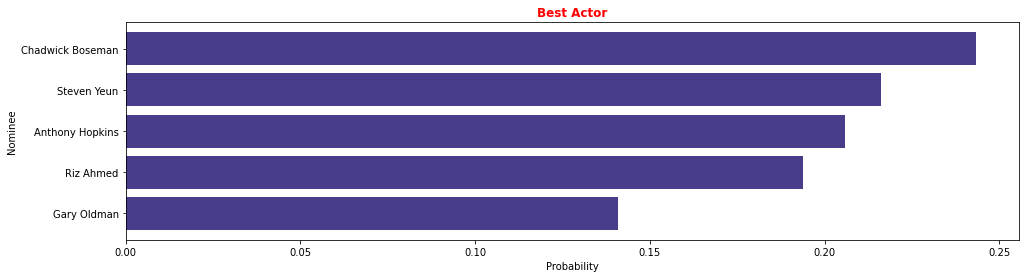

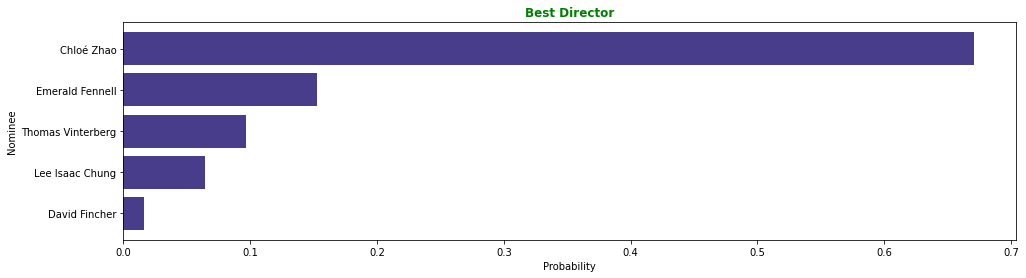

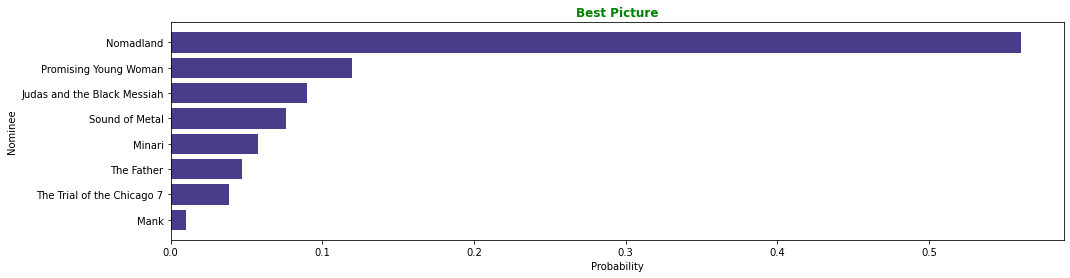

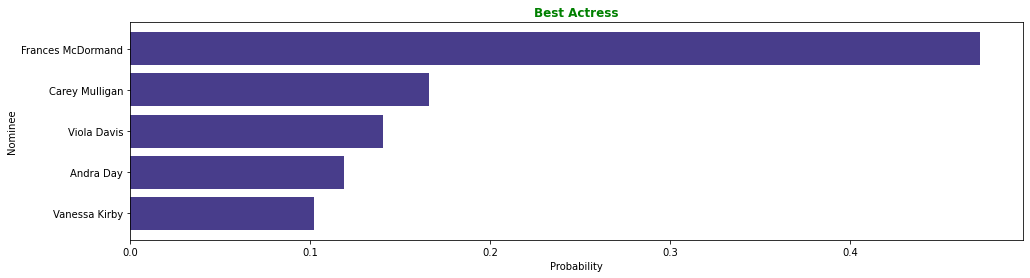

In [15]:
plot_all_predictions(predict_logistic_regression)

### Random forest

In [16]:
def predict_random_forest(category: str) -> pd.DataFrame:
    train_X, train_Y = get_train(category) 
    rfc = RandomForestClassifier(n_estimators = 300, random_state=4)
    rfc.fit(train_X, train_Y)
    return predict(rfc, category)

In [ ]:
plot_all_predictions(predict_random_forest)

### XGboost

In [ ]:
def predict_xgboost(category: str) -> pd.DataFrame:
    train_X, train_Y = get_train(category)    
    xgbc = XGBClassifier(use_label_encoder=False) 
    xgbc.fit(train_X, train_Y)
    return predict(xgbc, category)

In [ ]:
plot_all_predictions(predict_xgboost)

### Lightgbm

In [ ]:
def predict_lightgbm(category: str) -> pd.DataFrame:
    train_X, train_Y = get_train(category) 
    lgbmc = LGBMClassifier()
    lgbmc.fit(train_X, train_Y)
    return predict(lgbmc, category)

In [ ]:
plot_all_predictions(predict_lightgbm)